# Script to plot average causal effects - for different mechanisms

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


In [1]:
import numpy, os
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import math

In [2]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
arch = "gpt2-xl"
archname = "GPT-2-XL"

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'

LABELS = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]

class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(indeces, dirname, kind, do_normalize=False):
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]
    for i in tqdm(indeces):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        if do_normalize:
            scores = (scores-data["low_score"])/(data["high_score"]-data["low_score"])
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
    cbar_title="AIE"
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(LABELS)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if cbar_title:
        cb.ax.set_title(str(cbar_title).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()
    

def make_line_plot(result,
                   result_std,
                   low_score,
                   high_score,
                   archname,
                   savepdf,
                   ylabel="Average indirect effect on p(o)"
                  ):
    color_order = [0, 1, 2, 4, 5, 3]
    x = None

    cmap = plt.get_cmap("tab10")
    fig, ax = plt.subplots(figsize=(8, 3.5), dpi=200)
    for i, label in list(enumerate(LABELS)):
        y = result[i]
        if x is None:
            x = list(range(len(y)))
        std = result_std[i]
        error = std * 1.96 / math.sqrt(count)
        ax.fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        ax.plot(x, y, label=label, color=cmap.colors[color_order[i]])

        ax.set_ylabel(ylabel)
        ax.set_xlabel(f"Layer number in {archname}")
    ax.legend(frameon=False)
    plt.ylim([low_score, high_score])
    plt.tight_layout()
    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()

## Exact fact recall
Can use this information to decide on whether to only plot rank 0 predictions etc.

In [3]:
# note that plot file names need to be set!
DIRNAME = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/causal_trace_2377617/cases"
SAVEFOLDER = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/summary_pdfs/exact_recall"
data = pd.read_json("../../data/eval_on_fact_recall_set/gpt2-xl/1000_exact.json")
data.head()

,attribute,subject,relation_id,source,prompt,template,sub_view_rates,obj_view_rates,prediction,p_answers,rank_answers,string_match,person_name,used_template,prompt_bias,correct,surface_pred,consistency_counts,confident,known_id
0,Tunisia,Tunis,P1376,TREx_UHN,"Tunis, that is the capital city of","[X], that is the capital city of [Y]",25276.000000,131137.916667,Tunisia,0.795812,0,False,False,"[X], that is the capital city of",False,True,False,6,True,0
1,France,Coulommiers cheese,P495,TREx_UHN,Coulommiers cheese was formulated in,[X] was formulated in [Y],1170.250000,424490.500000,France,0.075174,2,False,False,[X] was formulated in,False,True,False,12,True,1
2,Italy,Bolognese sauce,P495,TREx_UHN,"Bolognese sauce, developed in","[X], developed in [Y]",46803.500000,338858.666667,Italy,0.150105,1,False,False,"[X], developed in",False,True,False,13,True,2
3,Japan,J-pop,P495,TREx_UHN,"J-pop, that was formed in","[X], that was formed in [Y]",14959.333333,491464.833333,Japan,0.035578,1,False,False,"[X], that was formed in",False,True,False,13,True,3
4,Qatar,Hamad bin Khalifa Al Thani,P27,TREx_UHN,Hamad bin Khalifa Al Thani is a citizen of,[X] is a citizen of [Y],25450.250000,224770.583333,Qatar,0.403077,0,False,False,[X] is a citizen of,False,True,False,7,True,4


The data contains predictions with ranks ranging between 0 (top) and 2.

In [4]:
data.value_counts("rank_answers", sort=False)

rank_answers
0    545
1    300
2    155
dtype: int64

### Plot average causal effects
Plot for all predictions, regardless of rank

In [5]:
kind = "mlp"
d = read_knowlege(indeces=data.known_id.values, dirname=DIRNAME, kind=kind)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"] - d["low_score"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1000/1000 [00:03<00:00, 287.85it/s]

Average Total Effect [0.4018664]
Best average indirect effect on last subject 0.1786536101458605
Best average indirect effect on last token 0.014069519212656815
Average best-fixed score 0.27159327
Average best-fixed on last subject token score 0.26366657
Average best-fixed on last word score 0.024132984
Argmax at last subject token 15
Max at last subject token 0.18606167
Argmax at last prompt token 35
Max at last prompt token 0.021477574


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


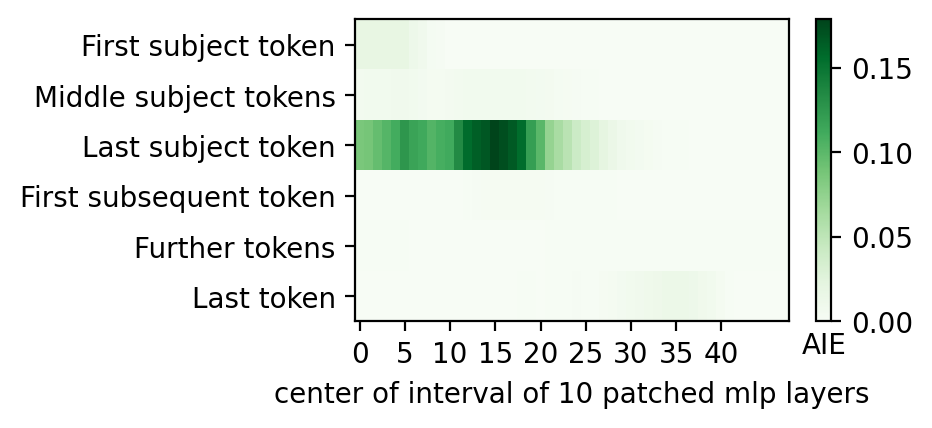

In [6]:
high_score = None

plot_array(
    result[:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks.pdf"),
)

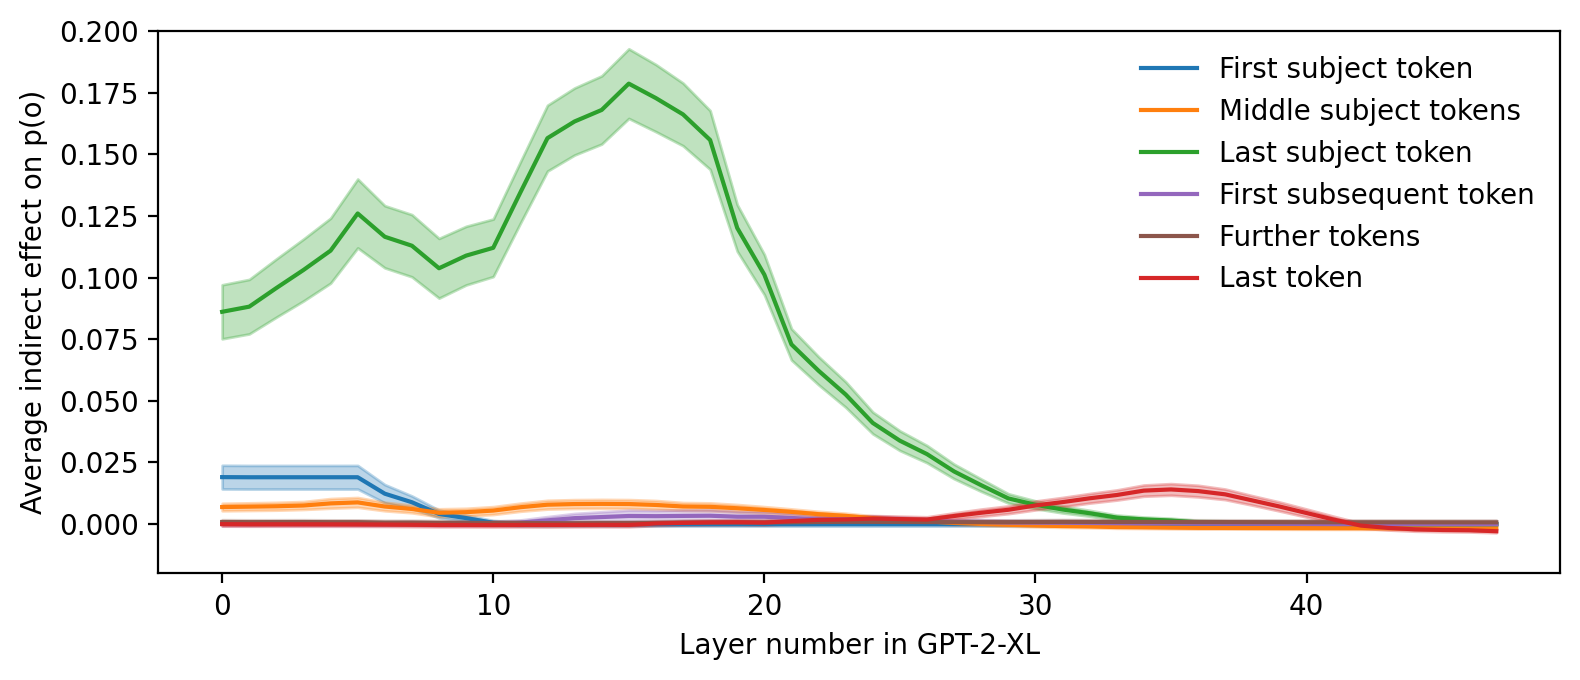

In [7]:
high_score = 0.2
low_score = -0.02
result = d["result"] - d["low_score"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "line_plot_all_ranks.pdf"),
)

Normalized

In [8]:
kind = "mlp"
d = read_knowlege(indeces=data.known_id.values, dirname=DIRNAME, kind=kind,
                 do_normalize=True)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1000/1000 [00:04<00:00, 239.77it/s]

Average Total Effect [0.4018664]
Best average indirect effect on last subject 0.3183885190842684
Best average indirect effect on last token 0.05218387881498893
Average best-fixed score 0.64364415
Average best-fixed on last subject token score 0.5476575
Average best-fixed on last word score 0.07720432
Argmax at last subject token 15
Max at last subject token 0.32579657
Argmax at last prompt token 34
Max at last prompt token 0.059591934


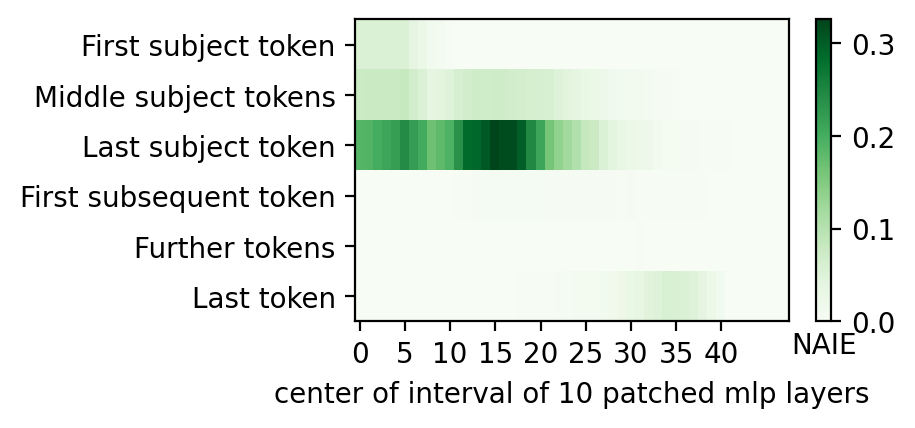

In [9]:
high_score = None

plot_array(
    d["result"][:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks_norm.pdf"),
    cbar_title="NAIE"
)

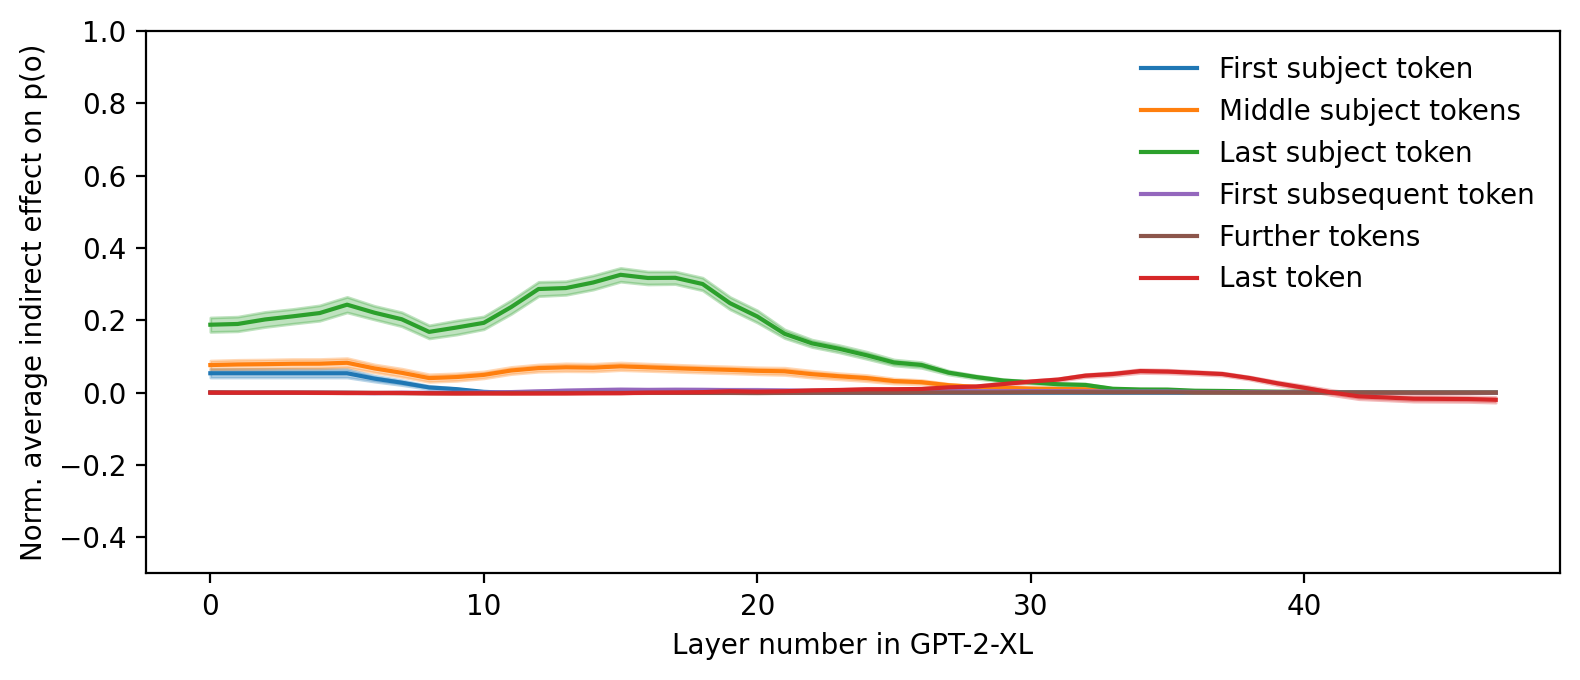

In [10]:
high_score = 1
low_score = -0.5
result = d["result"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "norm_line_plot_all_ranks.pdf"),
    ylabel="Norm. average indirect effect on p(o)"
)

Plot only for rank 0

In [11]:
kind = "mlp"
d = read_knowlege(indeces=data[data.rank_answers==0].known_id.values, dirname=DIRNAME, kind=kind)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"] - d["low_score"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 545/545 [00:01<00:00, 323.81it/s]

Average Total Effect [0.6690491]
Best average indirect effect on last subject 0.3130520030623235
Best average indirect effect on last token 0.020545198372558533
Average best-fixed score 0.4528696
Average best-fixed on last subject token score 0.44771203
Average best-fixed on last word score 0.0321173
Argmax at last subject token 15
Max at last subject token 0.32119882
Argmax at last prompt token 35
Max at last prompt token 0.028692016


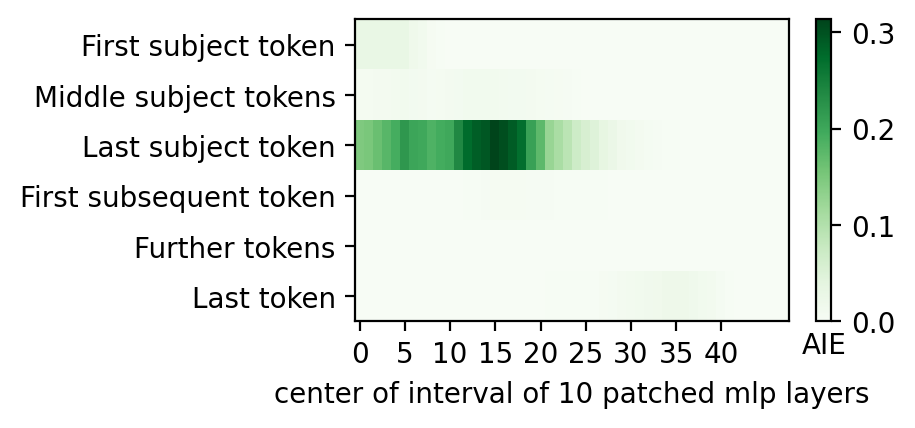

In [12]:
high_score = None

plot_array(
    result[:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "rank_0.pdf"),
)

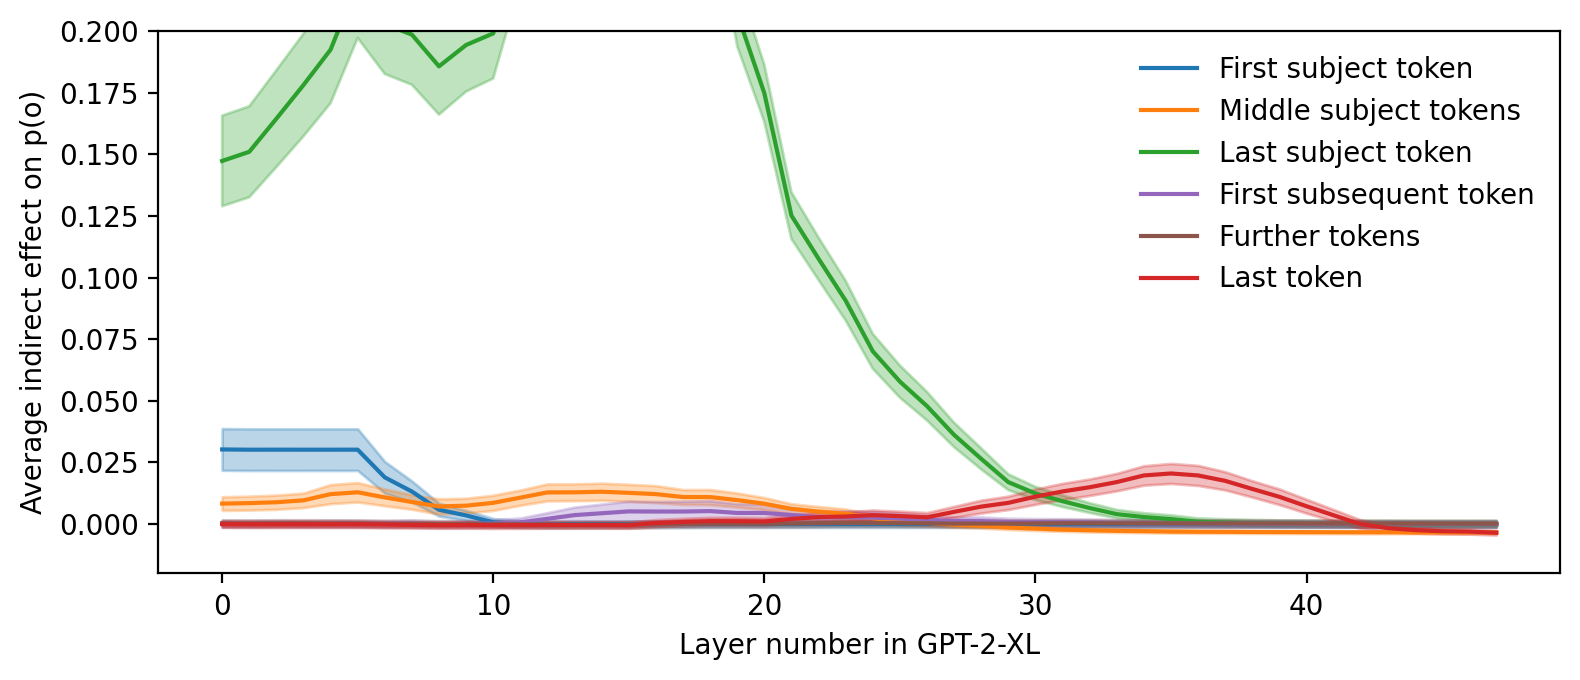

In [13]:
high_score = 0.2
low_score = -0.02
result = d["result"] - d["low_score"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "line_plot_all_ranks.pdf"),
)

Normalized

In [14]:
kind = "mlp"
d = read_knowlege(indeces=data[data.rank_answers==0].known_id.values, dirname=DIRNAME, kind=kind,
                 do_normalize=True)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 545/545 [00:02<00:00, 218.56it/s]

Average Total Effect [0.6690491]
Best average indirect effect on last subject 0.4317465170985021
Best average indirect effect on last token 0.02752382380421537
Average best-fixed score 0.6569967
Average best-fixed on last subject token score 0.64423
Average best-fixed on last word score 0.042094566
Argmax at last subject token 15
Max at last subject token 0.43989334
Argmax at last prompt token 35
Max at last prompt token 0.03567064


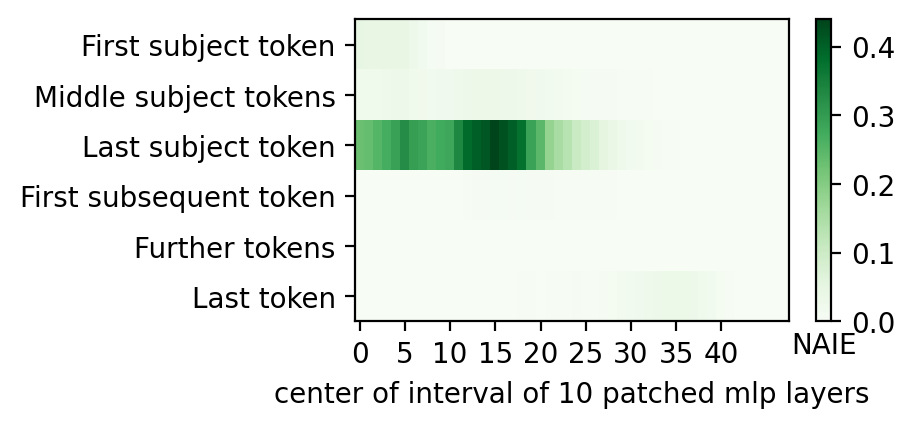

In [15]:
high_score = None

plot_array(
    d["result"][:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "rank_0_norm.pdf"),
    cbar_title="NAIE"
)

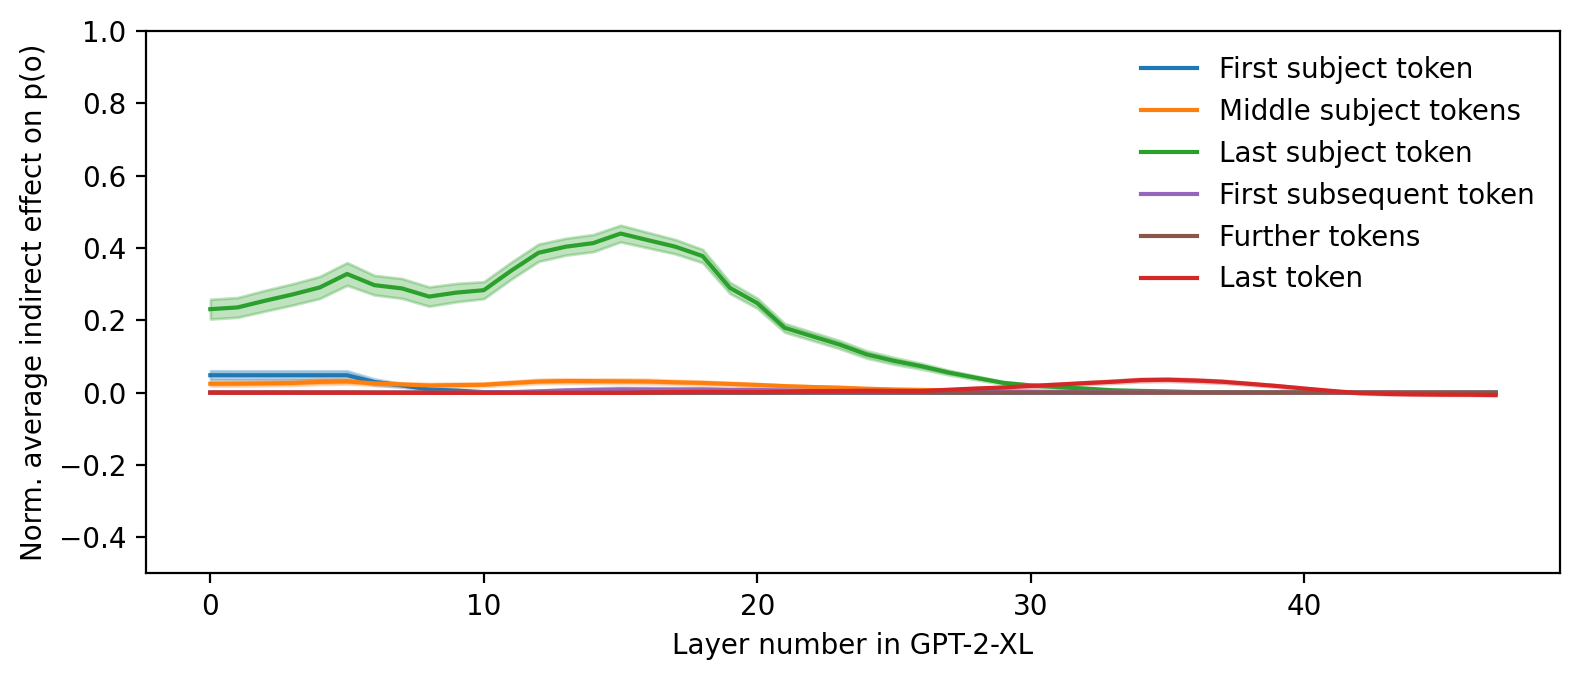

In [16]:
high_score = 1
low_score = -0.5
result = d["result"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "norm_line_plot_all_ranks.pdf"),
    ylabel="Norm. average indirect effect on p(o)"
)

Plot only for rank 2

In [17]:
kind = "mlp"
d = read_knowlege(indeces=data[data.rank_answers==2].known_id.values, dirname=DIRNAME, kind=kind)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"] - d["low_score"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 155/155 [00:00<00:00, 245.74it/s]

Average Total Effect [0.04238917]
Best average indirect effect on last subject 0.00836631474569825
Best average indirect effect on last token 0.0037722923375704638
Average best-fixed score 0.030831734
Average best-fixed on last subject token score 0.021407166
Average best-fixed on last word score 0.009950544
Argmax at last subject token 18
Max at last subject token 0.013594191
Argmax at last prompt token 34
Max at last prompt token 0.009000168


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


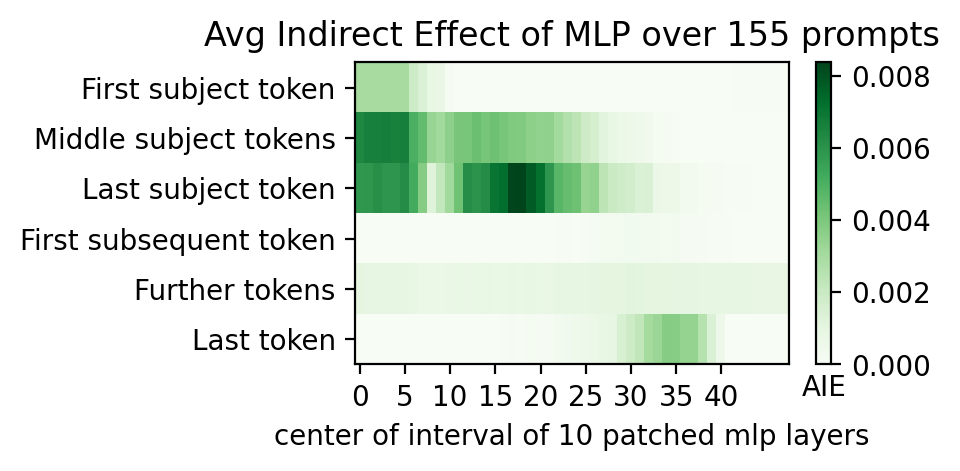

In [18]:
high_score = None

plot_array(
    result[:,:,0],
    kind=kind,
    title=title,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "rank_2.pdf"),
)

## Accurate samples

In [19]:
# note that plot file names need to be set!
DIRNAME = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/causal_trace_acc_2379451/cases"
SAVEFOLDER = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/summary_pdfs/accurate"
data = pd.read_json("../../data/eval_on_fact_recall_set/gpt2-xl/1000_accurate.json")
data.head()

,attribute,subject,relation_id,source,prompt,template,sub_view_rates,obj_view_rates,prediction,p_answers,rank_answers,string_match,person_name,used_template,prompt_bias,correct,surface_pred,consistency_counts,confident,known_id
0,Japan,Josetsu,P27,TREx_UHN,"Josetsu, who holds a citizenship of","[X], who holds a citizenship of [Y]",531.166667,491464.833333,Japan,0.231277,1,False,True,"[X], who holds a citizenship of",False,True,True,7,True,0
1,Gujarat,Gandhinagar,P1376,TREx_UHN,"Gandhinagar, that is the capital city of","[X], that is the capital city of [Y]",13896.750000,112637.000000,Gujarat,0.183950,1,False,False,"[X], that is the capital city of",False,True,False,6,True,1
2,France,Le Vieux Cordelier,P495,TREx_UHN,"Le Vieux Cordelier, that originated in","[X], that originated in [Y]",392.000000,424490.500000,France,0.090618,1,False,False,"[X], that originated in",True,True,True,1,False,2
3,France,De Dietrich Ferroviaire,P495,TREx_UHN,De Dietrich Ferroviaire was from,[X] was from [Y],396.333333,424490.500000,France,0.015576,2,False,False,[X] was from,False,True,False,6,True,3
4,Sweden,Stockholm,P1376,TREx_UHN,"Stockholm, the capital city of","[X], the capital city of [Y]",91022.833333,309365.750000,Sweden,0.793231,0,False,False,"[X], the capital city of",False,True,False,6,True,4


In [20]:
data.rank_answers.value_counts()

1    392
0    339
2    269
Name: rank_answers, dtype: int64

In [21]:
kind = "mlp"
d = read_knowlege(indeces=data.known_id.values, dirname=DIRNAME, kind=kind)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"] - d["low_score"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1000/1000 [00:04<00:00, 249.74it/s]

Average Total Effect [0.17794809]
Best average indirect effect on last subject 0.049306310481260884
Best average indirect effect on last token 0.013085320359896287
Average best-fixed score 0.1274644
Average best-fixed on last subject token score 0.10248803
Average best-fixed on last word score 0.034163315
Argmax at last subject token 18
Max at last subject token 0.067063555
Argmax at last prompt token 35
Max at last prompt token 0.030842565


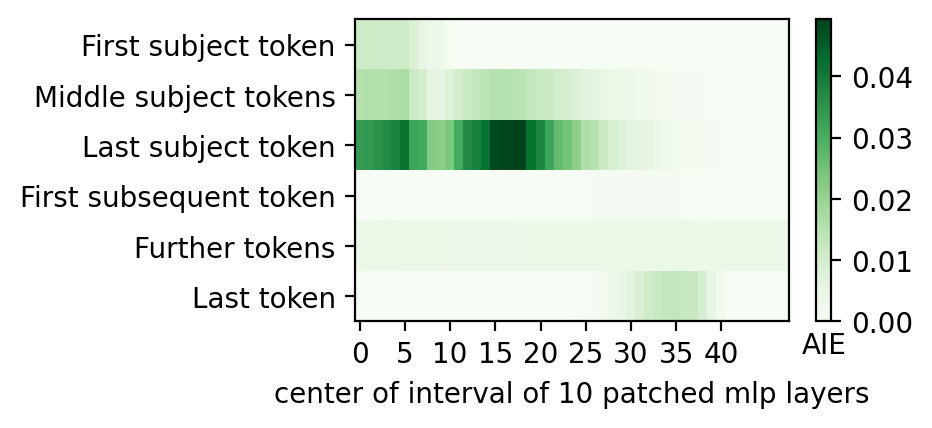

In [22]:
high_score = None

plot_array(
    result[:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks.pdf"),
)

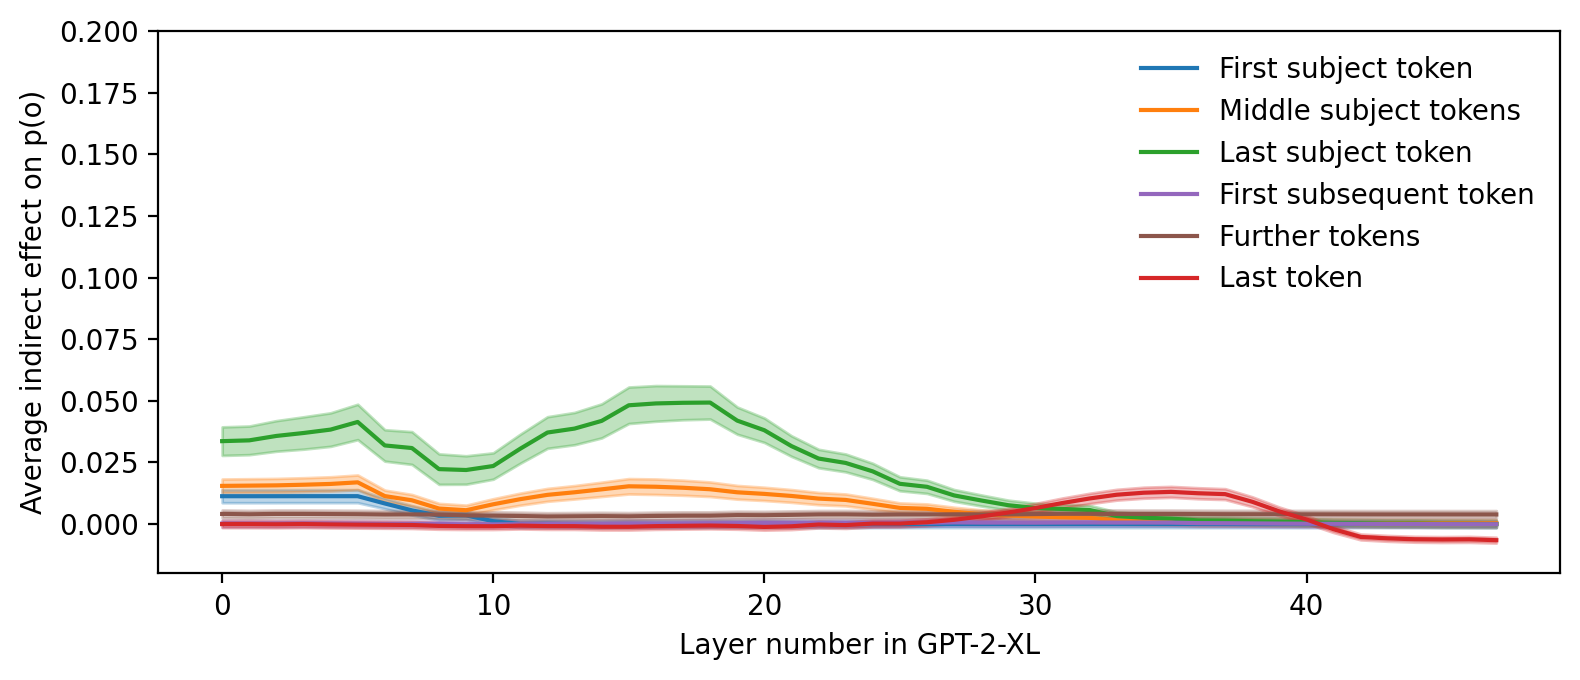

In [23]:
high_score = 0.2
low_score = -0.02
result = d["result"] - d["low_score"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "line_plot_all_ranks.pdf"),
)

Normalized

In [24]:
kind = "mlp"
d = read_knowlege(indeces=data.known_id.values, dirname=DIRNAME, kind=kind,
                 do_normalize=True)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1000/1000 [00:05<00:00, 175.56it/s]

Average Total Effect [0.17794809]
Best average indirect effect on last subject 0.5092570108835207
Best average indirect effect on last token 0.12067700154228078
Average best-fixed score 1.185638
Average best-fixed on last subject token score 0.8767577
Average best-fixed on last word score 0.2646187
Argmax at last subject token 5
Max at last subject token 0.52701426
Argmax at last prompt token 35
Max at last prompt token 0.13843425


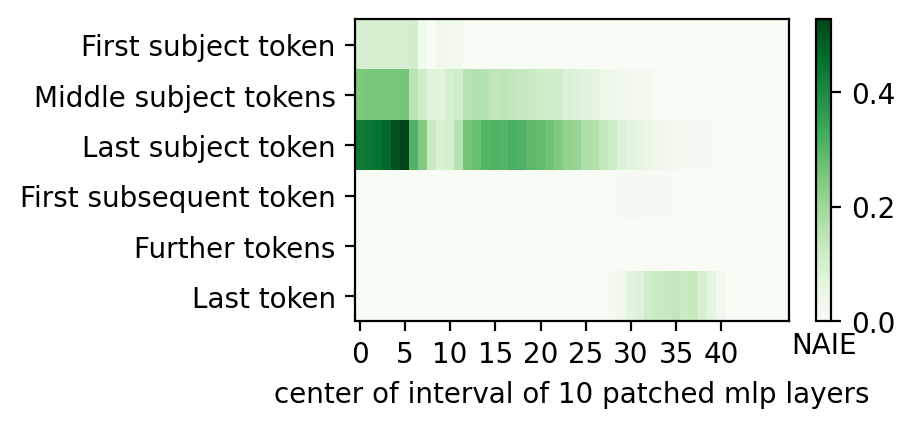

In [25]:
high_score = None

plot_array(
    d["result"][:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks_norm.pdf"),
    cbar_title="NAIE"
)

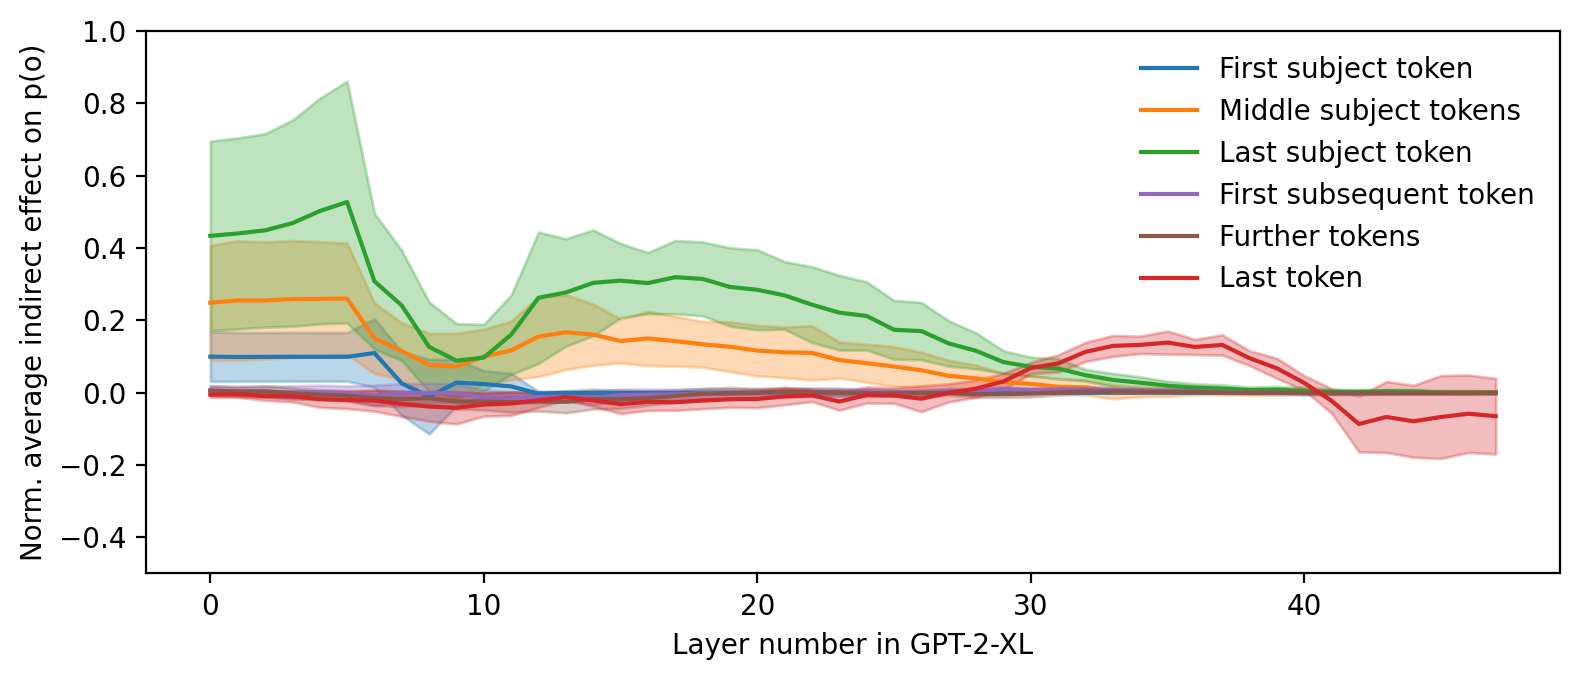

In [26]:
high_score = 1
low_score = -0.5
result = d["result"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "norm_line_plot_all_ranks.pdf"),
    ylabel="Norm. average indirect effect on p(o)"
)

## Accurate rank 0 samples

In [27]:
# note that plot file names need to be set!
DIRNAME = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/causal_trace_acc_rank_0_2379452/cases"
SAVEFOLDER = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/summary_pdfs/accurate_rank_0"
data = pd.read_json("../../data/eval_on_fact_recall_set/gpt2-xl/1000_accurate_rank_0.json")
data.head()

,attribute,subject,relation_id,source,prompt,template,sub_view_rates,obj_view_rates,prediction,p_answers,rank_answers,string_match,person_name,used_template,prompt_bias,correct,surface_pred,consistency_counts,confident,known_id
0,Louisiana,Baton Rouge,P1376,TREx_UHN,"Baton Rouge, the capital city of","[X], the capital city of [Y]",4149.083333,104960.916667,Louisiana,0.876147,0,False,False,"[X], the capital city of",False,True,False,6,True,0
1,Japan,Rokkaku Yoshikata,P27,TREx_UHN,"Rokkaku Yoshikata, who has a citizenship of","[X], who has a citizenship of [Y]",255.916667,491464.833333,Japan,0.247988,0,False,True,"[X], who has a citizenship of",False,True,True,7,True,1
2,medicine,Paracelsus,P101,TREx_UHN,Paracelsus works in the field of,[X] works in the field of [Y],25427.083333,65566.666667,medicine,0.132802,0,False,False,[X] works in the field of,True,True,True,1,False,2
3,Japan,Ken Okuyama,P27,TREx_UHN,Ken Okuyama holds a citizenship of,[X] holds a citizenship of [Y],2498.750000,491464.833333,Japan,0.511485,0,False,True,[X] holds a citizenship of,False,True,True,7,True,3
4,Japan,Kinji Fukasaku,P27,TREx_UHN,Kinji Fukasaku has a citizenship of,[X] has a citizenship of [Y],3678.750000,491464.833333,Japan,0.372865,0,False,True,[X] has a citizenship of,False,True,True,7,True,4


In [28]:
data.rank_answers.value_counts()

0    1000
Name: rank_answers, dtype: int64

In [29]:
kind = "mlp"
d = read_knowlege(indeces=data.known_id.values, dirname=DIRNAME, kind=kind)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"] - d["low_score"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1000/1000 [00:04<00:00, 223.79it/s]

Average Total Effect [0.38725007]
Best average indirect effect on last subject 0.11393727498781846
Best average indirect effect on last token 0.024290339524866793
Average best-fixed score 0.25002488
Average best-fixed on last subject token score 0.21314803
Average best-fixed on last word score 0.054979675
Argmax at last subject token 16
Max at last subject token 0.14004157
Argmax at last prompt token 35
Max at last prompt token 0.05039464


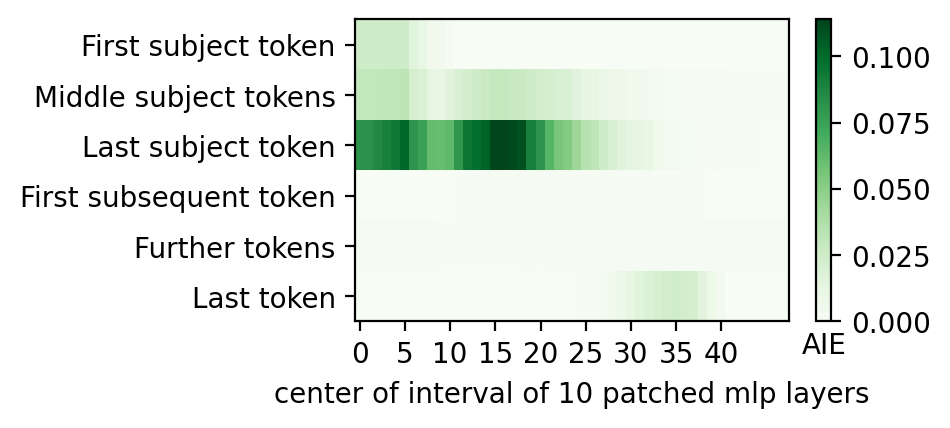

In [30]:
high_score = None

plot_array(
    result[:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks.pdf"),
)

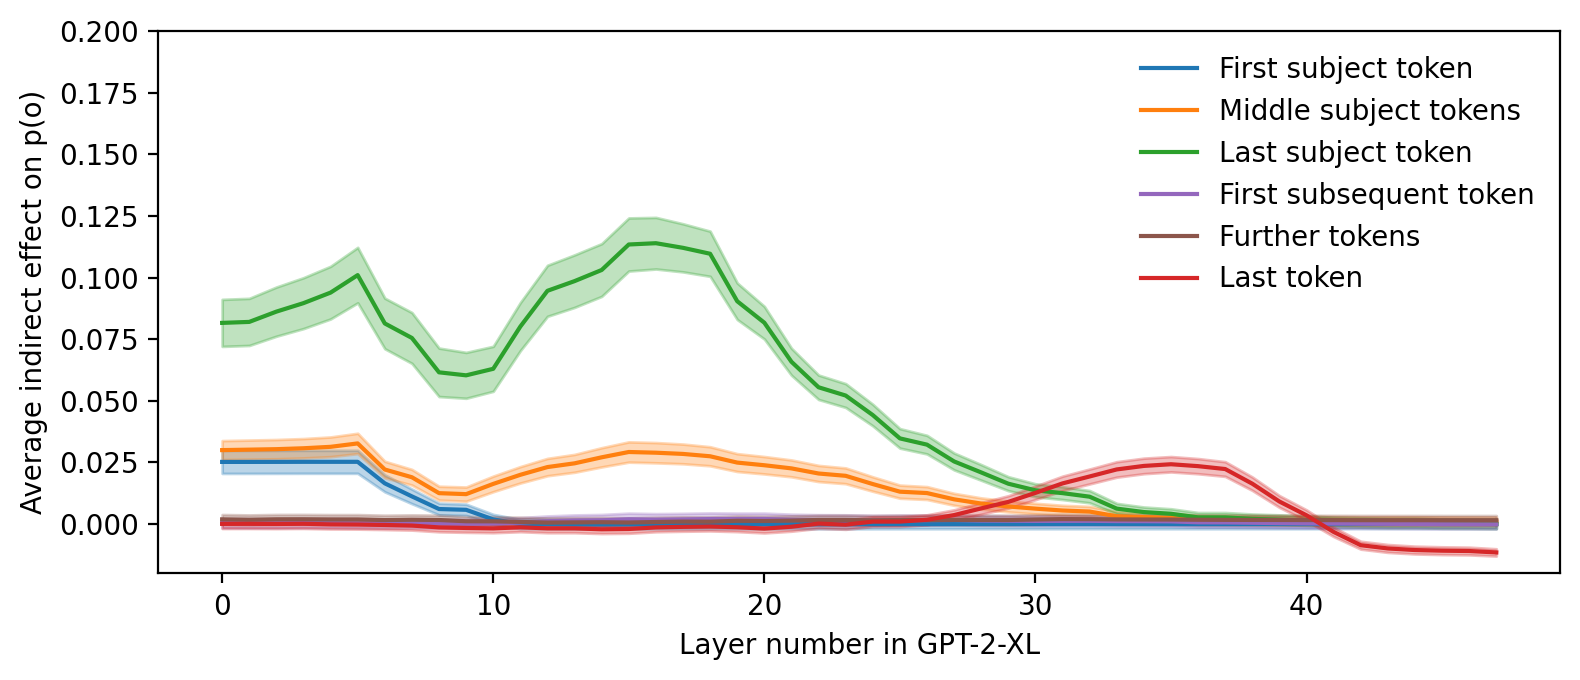

In [31]:
high_score = 0.2
low_score = -0.02
result = d["result"] - d["low_score"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "line_plot_all_ranks.pdf"),
)

Normalized

In [32]:
kind = "mlp"
d = read_knowlege(indeces=data.known_id.values, dirname=DIRNAME, kind=kind,
                 do_normalize=True)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1000/1000 [00:04<00:00, 209.87it/s]

Average Total Effect [0.38725007]
Best average indirect effect on last subject 0.2168775065494792
Best average indirect effect on last token 0.057753497238280035
Average best-fixed score 0.566608
Average best-fixed on last subject token score 0.4307675
Average best-fixed on last word score 0.100226074
Argmax at last subject token 18
Max at last subject token 0.2429818
Argmax at last prompt token 35
Max at last prompt token 0.0838578


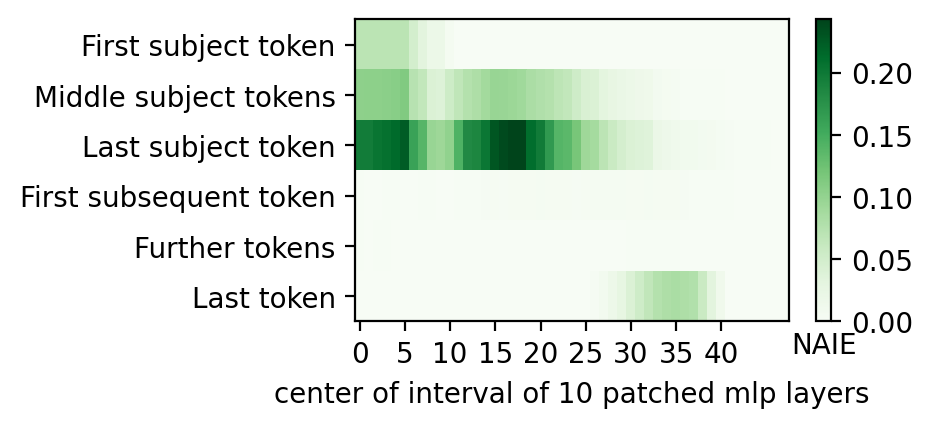

In [33]:
high_score = None

plot_array(
    d["result"][:,:,0],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks_norm.pdf"),
    cbar_title="NAIE"
)

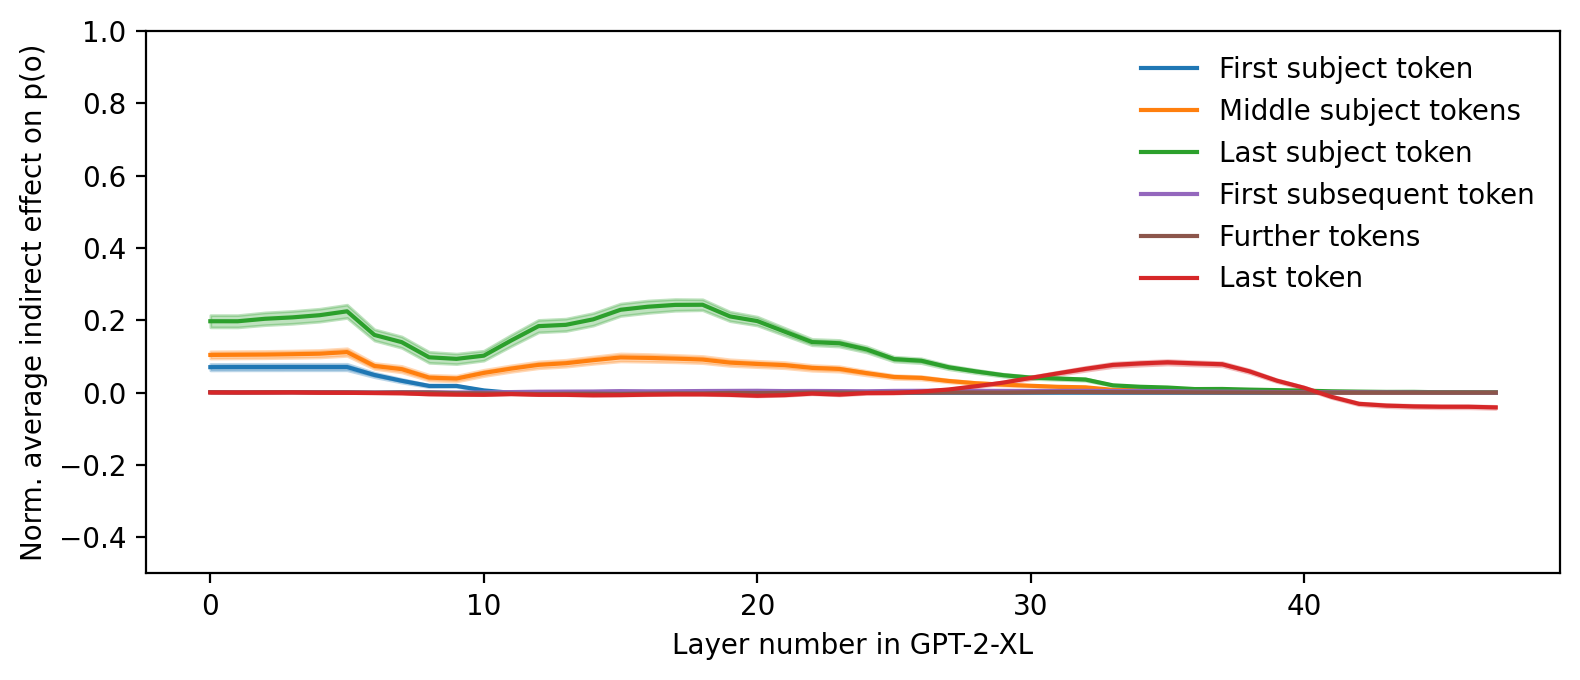

In [34]:
high_score = 1
low_score = -0.5
result = d["result"]
result_std = d["result_std"]

make_line_plot(
    result[:,:,0],
    result_std[:,:,0],
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "norm_line_plot_all_ranks.pdf"),
    ylabel="Norm. average indirect effect on p(o)"
)

## CounterFact

In [35]:
DIRNAME = "/cephyr/users/lovhag/Alvis/projects/rome/data/results/gpt2-xl/known_1000/causal_trace_1907775/cases"
SAVEFOLDER = "/cephyr/users/lovhag/Alvis/projects/rome/data/eval_on_fact_recall_set/gpt2-xl/summary_pdfs/knowns"
data = pd.read_json("../../data/known_1000.json")
data.head()

,known_id,subject,attribute,template,prediction,prompt,relation_id
0,0,Vinson Massif,Antarctica,{} is located in the continent,of Antarctica. It is the largest of the three,Vinson Massif is located in the continent of,P30
1,1,Beats Music,Apple,{} is owned by,"Apple, which is also the owner of Beats Elect...",Beats Music is owned by,P127
2,2,Audible.com,Amazon,{} is owned by,"Amazon.com, Inc. or its affiliates.",Audible.com is owned by,P127
3,3,The Big Bang Theory,CBS,{} premieres on,CBS on September 22.<|endoftext|>,The Big Bang Theory premieres on,P449
4,4,MacApp,Apple,"{}, a product created by",Apple to help developers create apps for the ...,"MacApp, a product created by",P178


### Plot average causal effects

In [36]:
kind = "mlp"
d = read_knowlege(indeces=data.iloc[:1001].known_id.values, dirname=DIRNAME, kind=kind)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"] - d["low_score"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1001/1001 [00:04<00:00, 212.91it/s]

Average Total Effect 0.2317593319254338
Best average indirect effect on last subject 0.05873299370579116
Best average indirect effect on last token 0.025940745873969717
Average best-fixed score 0.1770642
Average best-fixed on last subject token score 0.14164652
Average best-fixed on last word score 0.07141984
Argmax at last subject token 17
Max at last subject token 0.09685488
Argmax at last prompt token 35
Max at last prompt token 0.06406263


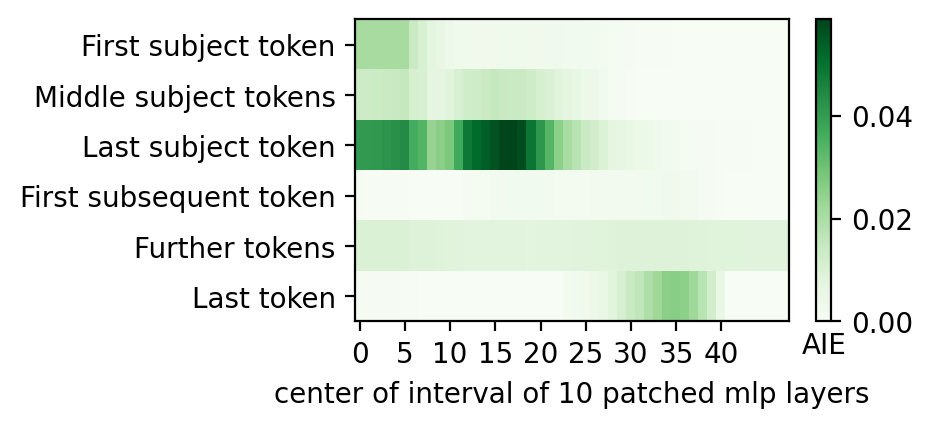

In [37]:
high_score = None

plot_array(
    result,
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks.pdf"),
)

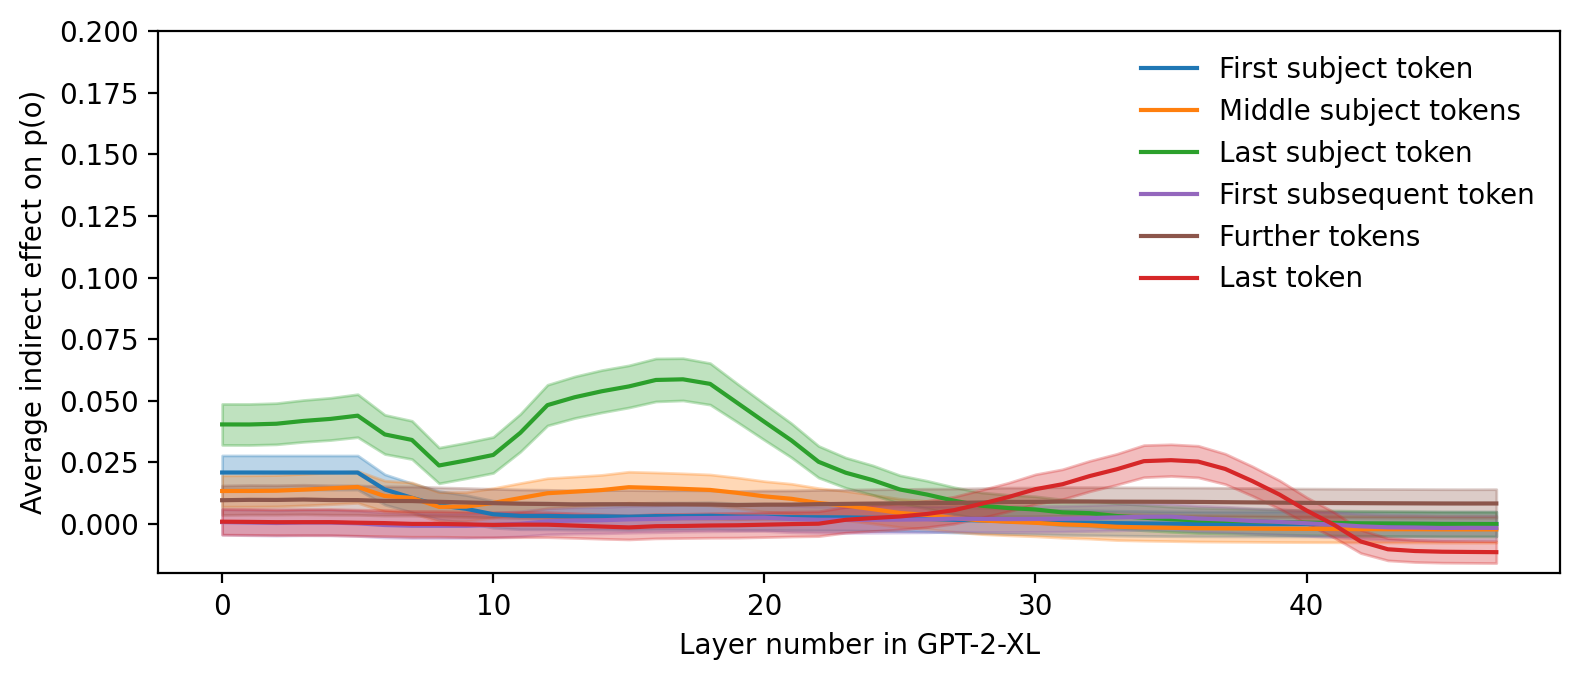

In [38]:
high_score = 0.2
low_score = -0.02
result = d["result"] - d["low_score"]
result_std = d["result_std"]

make_line_plot(
    result,
    result_std,
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "line_plot_all_ranks.pdf"),
)

Normalized

In [39]:
kind = "mlp"
d = read_knowlege(indeces=data.iloc[:1001].known_id.values, dirname=DIRNAME, kind=kind,
                 do_normalize=True)
count = d["size"]
what = {
    None: "Indirect Effect of $h_i^{(l)}$",
    "mlp": "Indirect Effect of MLP",
    "attn": "Indirect Effect of Attn",
}[kind]
title = f"Avg {what} over {count} prompts"
result = numpy.clip(d["result"], 0, None)
kindcode = "" if kind is None else f"_{kind}"

100%|██████████| 1001/1001 [00:05<00:00, 182.34it/s]

Average Total Effect 0.2317593319254338
Best average indirect effect on last subject 0.24415677021316878
Best average indirect effect on last token 0.08201240728668563
Average best-fixed score 0.9522066
Average best-fixed on last subject token score 0.64776397
Average best-fixed on last word score 0.29287744
Argmax at last subject token 16
Max at last subject token 0.28227866
Argmax at last prompt token 34
Max at last prompt token 0.120134294


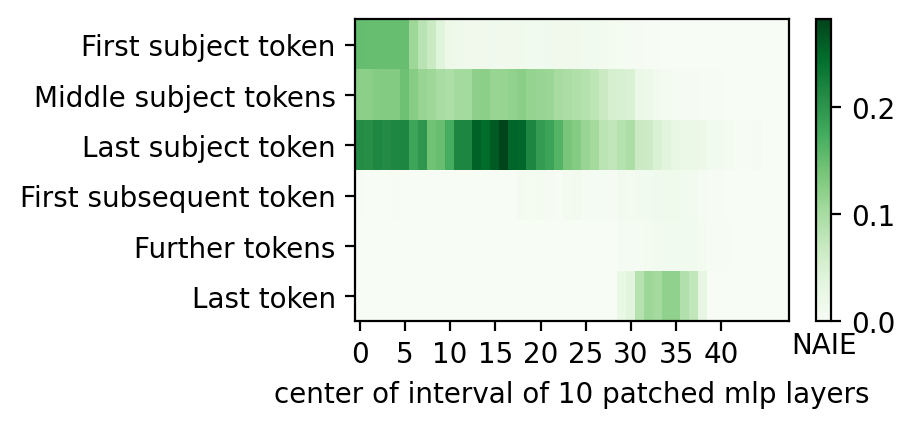

In [40]:
high_score = None

plot_array(
    d["result"],
    kind=kind,
    title=None,
    low_score=0.0,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "all_ranks_norm.pdf"),
    cbar_title="NAIE"
)

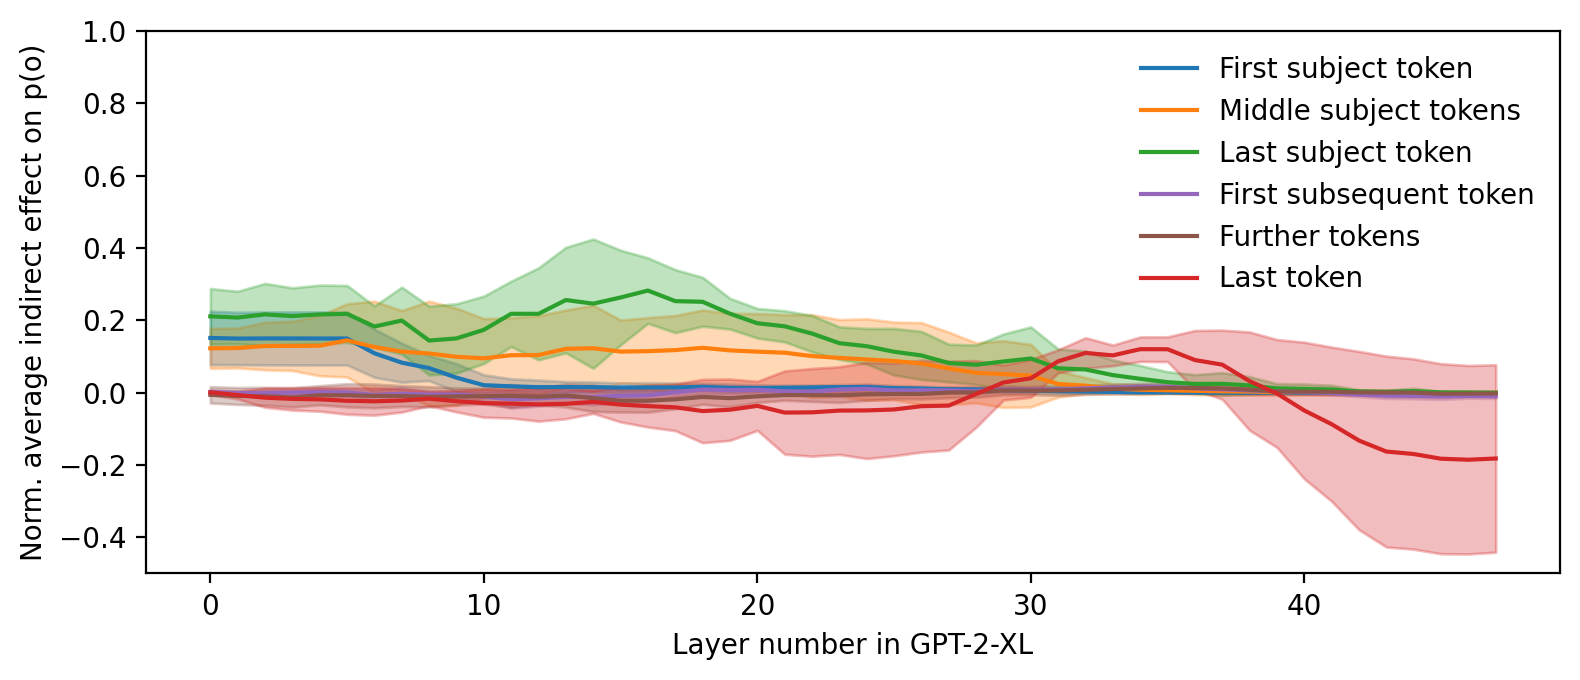

In [41]:
high_score = 1
low_score = -0.5
result = d["result"]
result_std = d["result_std"]

make_line_plot(
    result,
    result_std,
    low_score=low_score,
    high_score=high_score,
    archname=archname,
    savepdf=os.path.join(SAVEFOLDER, "norm_line_plot_all_ranks.pdf"),
    ylabel="Norm. average indirect effect on p(o)"
)